<a href="https://colab.research.google.com/github/FirgiK/Project-NLP-10/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Penjelasan Dataset Yang Digunakan***

### Dataset yang digunakan dalam penelitian ini merupakan kumpulan data teks yang diekstraksi dari platform media sosial X (sebelumnya Twitter), yang berkaitan dengan isu konflik di Palestina. Dataset ini memuat beberapa atribut, antara lain tautan unggahan, isi teks cuitan, identitas pengguna dalam bentuk nama akun, serta indikator interaksi seperti jumlah likes, retweets, quotes, dan comments. Selain itu, dataset turut dilengkapi dengan label klasifikasi yang merepresentasikan kategori sentimen atau posisi opini terhadap konflik yang dimaksud. Penggunaan dataset ini bertujuan untuk menganalisis pola persepsi publik, kecenderungan opini, serta dinamika penyebaran informasi terkait konflik Palestina melalui jejaring media sosial. Dengan demikian, dataset ini relevan sebagai dasar dalam penerapan metode pemrosesan bahasa alami dan analisis sentimen pada penelitian ini.

"""
# 1. Penjelasan Dataset yang Digunakan

## 1. Kasus yang diambil

Dataset yang digunakan dalam penelitian ini merupakan kumpulan data teks yang diekstraksi dari platform media sosial X (sebelumnya Twitter), yang berkaitan dengan isu konflik di Palestina. Penggunaan dataset ini bertujuan untuk menganalisis pola persepsi publik, kecenderungan opini, serta dinamika penyebaran informasi terkait konflik Palestina melalui jejaring media sosial.

## 2. Penjelasan setiap kolomnya

* **number, link, user**: Metadata terkait cuitan (ID, URL, dan penulis).
* **text**: Teks asli dari cuitan (fitur utama untuk analisis).
* **likes, quotes, retweets, comments**: Metrik interaksi (tidak digunakan dalam pemodelan ini).
* **label**: Label kategori asli dari dataset (tidak digunakan, kita akan membuat label sendiri).
* **Unnamed: ...**: Kolom sisa dari proses impor CSV, akan dihapus.

## 3. Import Library
"""

In [19]:
# --- For data handling and analysis ---
import pandas as pd
import numpy as np
import re
import os
from collections import Counter

# --- For Natural Language Processing (NLP) ---
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- For Machine Learning (ML) ---
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- For Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- For Google Colab integration ---
from google.colab import drive

In [20]:
# --- Install and Download Dependencies ---

# Install necessary Python packages
!pip install transformers emoji matplotlib seaborn wordcloud vaderSentiment -q

# Download required NLTK data models
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) # Fixes the error from the original notebook
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [21]:
# --------------------------------------------------
# 4. Load Data
# --------------------------------------------------

# Set display options for Pandas
pd.set_option('display.max_colwidth', None)

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("\nGoogle Drive mounted successfully.")
except Exception as e:
    print(f"\nError mounting Google Drive: {e}")

# Define file path and read the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP_Sentimen/DataSet_X.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from: {file_path}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Google Drive mounted successfully.
Successfully loaded data from: /content/drive/MyDrive/Colab Notebooks/NLP_Sentimen/DataSet_X.csv


,number,link,text,user,likes,quotes,retweets,comments,label,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,https://twitter.com/BabylonBulletin/status/1717692568689918166#m,"🚨 #BREAKING 🚨 A high-ranking member of Israeli special forces has been captured. For the latest updates, follow @BabylonBulletin. #Gaza #Israel",Babylon Bulletin,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2,https://twitter.com/lixi32730051/status/1717692549044035607#m,#BREAKING The #Palestinian Islamic Resistance Movement (#Hamas ) claimed that nearly 50 people detained in the #Gaza Strip were killed in #Israeli airstrikes. #Israel,Journalist Lixy,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,3,https://twitter.com/ursala_yacoob/status/1717692493553369355#m,"Stop Israel’s atrocities, genocide massacring innocent civilians. Entire generations of families are being wiped out. Barbaric. #StopGenocide #EndApartheid #Gaza #FreePalestine #FreePalestineFormZionistOccupation 💯🇵🇸🇵🇸🇵🇸🇵🇸",Ursala Yacoob 🇵🇸🍉,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN
3,4,https://twitter.com/ellisonbarber/status/1717692462406262824#m,"If the walls of #Gaza’s Al Shifa hospital could talk, they’d tell a story of a perpetual hell… **WARNING: the things you’ll see and hear in this report are graphic**",Ellison Barber,50,4,21,14,1,NaN,NaN,NaN,NaN,NaN
4,5,https://twitter.com/JohnLocker4/status/1717692424624177571#m,The people of #Gaza needs to kick #HamasNazis out #Hamas attacked #Israelis At a freaking music festival Raped women beheaded babies shot peoples dogs retaliation was expected. & used as weapon by the scumbag #HamasTerrorists,💧John Locker,0,0,0,1,5,NaN,NaN,NaN,NaN,NaN


# **Data Understanding**

--- Data Shape and Info ---
Original shape: (7387, 14)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7387 entries, 0 to 7386
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   number       7387 non-null   int64  
 1   link         7387 non-null   object 
 2   text         7387 non-null   object 
 3   user         7386 non-null   object 
 4   likes        7387 non-null   object 
 5   quotes       7387 non-null   object 
 6   retweets     7387 non-null   object 
 7   comments     7387 non-null   object 
 8   label        7387 non-null   object 
 9   Unnamed: 9   38 non-null     float64
 10  Unnamed: 10  5 non-null      float64
 11  Unnamed: 11  4 non-null      float64
 12  Unnamed: 12  4 non-null      float64
 13  Unnamed: 13  4 non-null      float64
dtypes: float64(5), int64(1), object(8)
memory usage: 808.1+ KB

Average character length of 'text' column: 196.60


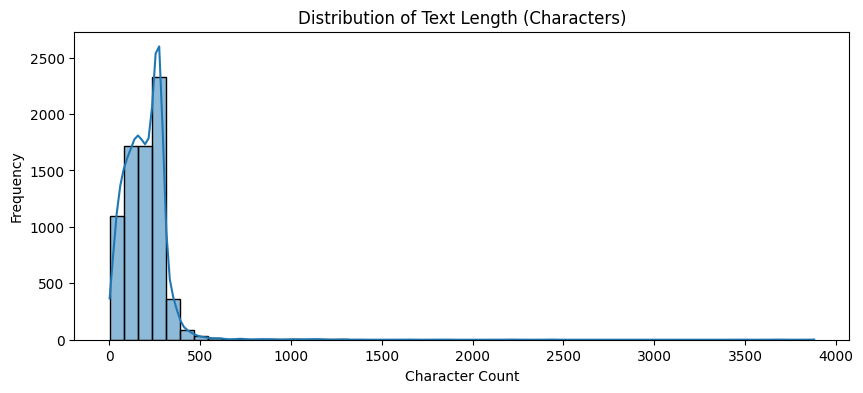

In [22]:
# --------------------------------------------------
# 1. Jumlah baris data
# --------------------------------------------------

print("--- Data Shape and Info ---")
print(f"Original shape: {df.shape}")
print("\nData Info:")
df.info()

# --------------------------------------------------
# 2. Panjang rata-rata setiap baris
# --------------------------------------------------

# Calculate character length of the 'text' column
df['text_length_char'] = df['text'].astype(str).apply(len)
average_text_length = df['text_length_char'].mean()
print(f"\nAverage character length of 'text' column: {average_text_length:.2f}")

# Plot distribution of text length
plt.figure(figsize=(10, 4))
sns.histplot(df['text_length_char'], bins=50, kde=True)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

In [23]:
# --------------------------------------------------
# 3. Cek data duplikasi
# --------------------------------------------------

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Removed duplicates. New shape: {df.shape}")

# --------------------------------------------------
# 4. Cek data kosong
# --------------------------------------------------

print("\n--- Missing Value Check ---")
print(df.isna().sum())

# Drop rows where 'user' is missing (as in original notebook)
df.dropna(subset=['user'], inplace=True)

# Drop unnamed columns that are mostly empty
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)
    print(f"\nDropped unnamed columns. Final columns: {df.columns.tolist()}")

print(f"\nFinal data shape after cleaning: {df.shape}")

Number of duplicate rows: 0

--- Missing Value Check ---
number                 0
link                   0
text                   0
user                   1
likes                  0
quotes                 0
retweets               0
comments               0
label                  0
Unnamed: 9          7349
Unnamed: 10         7382
Unnamed: 11         7383
Unnamed: 12         7383
Unnamed: 13         7383
text_length_char       0
dtype: int64

Dropped unnamed columns. Final columns: ['number', 'link', 'text', 'user', 'likes', 'quotes', 'retweets', 'comments', 'label', 'text_length_char']

Final data shape after cleaning: (7386, 10)


# 3. Data Text Processing

In [59]:
# --------------------------------------------------
# Cell 6: Text Preprocessing Pipeline
# --------------------------------------------------

# 1. Initialize tools
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

# 2. Define normalization maps and exceptions
lemma_exceptions = {'hamas'}
lemma_map = {
    'hama': 'hamas', 'israeli': 'israel', 'israelis': 'israel',
    'palestinian': 'palestine', 'palestinians': 'palestine'
}

# 3. Define stopwords
stop_words = set(stopwords.words('english'))
custom_stop_words = {
    'wa', 'idf', 'ha', 'say', 'said', 'make', 'must', 'still', 'call', 'even',
    'need', 'keep', 'want', 'go', 'give', 'get', 'come', 'see', 'tell', 'look',
    'know', 'think', 'let', 'use', 'used', 'take', 'put', 'mean',
    'one', 'people', 'day', 'time', 'year', 'way', 'part', 'thing', 'life', 'world',
    'group', 'number', 'many', 'another', 'work', 'back', 'well', 'really', 'amp',
    'video', 'youtube', 'via', 'online', 'read', 'news', 'post', 'tweet',
    'breaking', 'live', 'feed_id', 'us', 'also', 'like', 'new', 'much',
    'right', 'action', 'may', 'never', 'every', 'always', 'going',
    'talk', 'watch', 'show', 'report', 'article', 'medium', 'please',
    'piped', 'ceasefirenow', 'wordwar', 'si', 'two', 'im', 'de', 'le', 'un',
    'doe', 'yet', 'org', 'short', 'first', 'end', 'face', 'continue', 'called',
    'last', 'made', 'city', 'word', 'help', 'money', 'home', 'plan', 'power',
    'newsonlineread', 'today', 'start', 'stand', 'calling',
    'full', 'share', 'everyone', 'already', 'story', 'history', 'point',
    'place', 'care', 'name',
    '_unique_id', 'unique_id', 'gazagenocide', 'freepalestine', 'gazagaza', 'gaza_genocide',
    'en', 'israel', 'gaza', 'hamas', 'palestine', 'palestina', 'idf',
    'gazagenocide', 'freepalestine', 'gazagaza', 'gaza_genocide',
}
all_words_to_remove = stop_words.union(custom_stop_words)


# 4. Master processing function
def preprocess_text(text):
    """
    Applies tokenization, lemmatization, normalization, and stopword removal.
    """
    if not isinstance(text, str):
        return ""

    # 1. Tokenize
    tokens = tokenizer.tokenize(text)

    lemmatized_list = []
    for word in tokens:
        word_lower = word.lower()

        # 2. Normalize known words
        if word_lower in lemma_exceptions:
            lemmatized_list.append(word)
        elif word_lower in lemma_map:
            lemmatized_list.append(lemma_map[word_lower])
        # 3. Lemmatize other words
        else:
            lemmatized_list.append(lemmatizer.lemmatize(word))

    # 4. Remove stopwords and short words
    cleaned_tokens = [
        word for word in lemmatized_list
        if word.lower() not in all_words_to_remove and len(word) > 1
    ]

    return ' '.join(cleaned_tokens)

# 5. Apply the pipeline to the DataFrame
print("Applying text preprocessing pipeline to 'text' column...")
df['text_cleaned_string'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")

# Display results
display(df[['text', 'text_cleaned_string']].head())

Applying text preprocessing pipeline to 'text' column...
Preprocessing complete.


,text,text_cleaned_string
0,"🚨 #BREAKING 🚨 A high-ranking member of Israeli special forces has been captured. For the latest updates, follow @BabylonBulletin. #Gaza #Israel",high ranking member special force captured latest update follow BabylonBulletin
1,#BREAKING The #Palestinian Islamic Resistance Movement (#Hamas ) claimed that nearly 50 people detained in the #Gaza Strip were killed in #Israeli airstrikes. #Israel,Islamic Resistance Movement claimed nearly 50 detained Strip killed airstrikes
2,"Stop Israel’s atrocities, genocide massacring innocent civilians. Entire generations of families are being wiped out. Barbaric. #StopGenocide #EndApartheid #Gaza #FreePalestine #FreePalestineFormZionistOccupation 💯🇵🇸🇵🇸🇵🇸🇵🇸",Stop atrocity genocide massacring innocent civilian Entire generation family wiped Barbaric StopGenocide EndApartheid FreePalestineFormZionistOccupation
3,"If the walls of #Gaza’s Al Shifa hospital could talk, they’d tell a story of a perpetual hell… **WARNING: the things you’ll see and hear in this report are graphic**",wall Al Shifa hospital could perpetual hell WARNING hear graphic
4,The people of #Gaza needs to kick #HamasNazis out #Hamas attacked #Israelis At a freaking music festival Raped women beheaded babies shot peoples dogs retaliation was expected. & used as weapon by the scumbag #HamasTerrorists,kick HamasNazis attacked freaking music festival Raped woman beheaded baby shot dog retaliation expected weapon scumbag HamasTerrorists


Generating WordCloud from cleaned text...


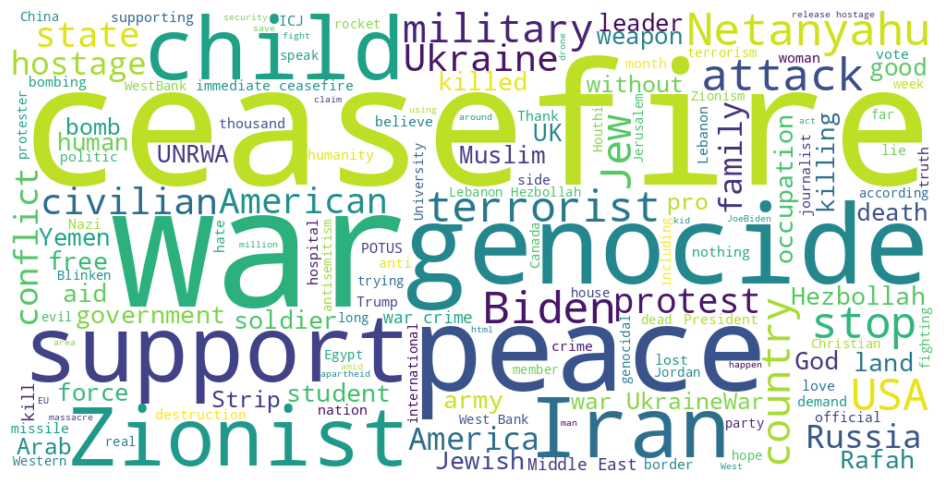

In [61]:
# --------------------------------------------------
# (Template 2.5) Distribusi data menggunakan Word Cloud
# --------------------------------------------------

print("Generating WordCloud from cleaned text...")
all_text = ' '.join(df['text_cleaned_string'])

if all_text.strip():
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap='viridis',
        max_words=150
    ).generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("No text available to generate WordCloud.")

Applying VADER sentiment labeling to original text...

Sentiment Label Distribution (from VADER):


,count
sentiment_label,
Negatif,3945
Positif,2348
Netral,1093


/tmp/ipython-input-1775958930.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


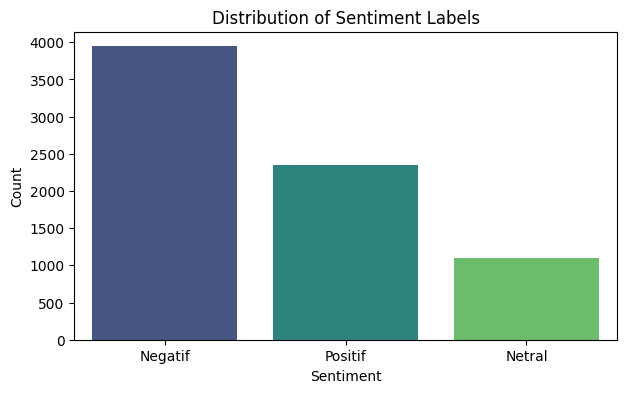

In [62]:
# --------------------------------------------------
# Cell 8: Sentiment Labeling (VADER)
# --------------------------------------------------

# 1. Initialize VADER
sia = SentimentIntensityAnalyzer()

# 2. Define labeling functions
def get_vader_compound_score(text):
    """Returns the compound polarity score (-1.0 to +1.0)"""
    if isinstance(text, float): # Handle empty/nan values
        return 0.0
    return sia.polarity_scores(str(text))['compound']

def get_sentiment_label(compound_score):
    """Classifies a compound score into a category"""
    if compound_score >= 0.05:
        return 'Positif'
    elif compound_score <= -0.05:
        return 'Negatif'
    else:
        return 'Netral'

# 3. Apply VADER labeling to the *original* 'text' column
print("Applying VADER sentiment labeling to original text...")
df['polarity_score'] = df['text'].apply(get_vader_compound_score)
df['sentiment_label'] = df['polarity_score'].apply(get_sentiment_label)

# 4. Display label distribution
print("\nSentiment Label Distribution (from VADER):")
label_counts = df['sentiment_label'].value_counts()
display(label_counts)

# 5. Plot label distribution
plt.figure(figsize=(7, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [63]:
# --------------------------------------------------
# Cell 9: Feature Engineering & Data Splitting
# --------------------------------------------------

# 1. Define X (features) and y (target)
X = df['text_cleaned_string']  # Features: cleaned text
y = df['sentiment_label']      # Target: VADER labels

# 2. Vectorize text using TF-IDF (Reset to 1-gram)
print("Vectorizing text with TF-IDF (max 5000 features, 1-gram)...")
vectorizer = TfidfVectorizer(max_features=5000) # Pastikan ngram_range tidak ada atau (1, 1)
X_tfidf = vectorizer.fit_transform(X)

# 3. Split data (80% train, 20% test)
print("Splitting data into 80% train / 20% test...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4. Show results
print("\n--- Data Shapes ---")
print(f"Total data: {X_tfidf.shape[0]}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Vectorizing text with TF-IDF (max 5000 features, 1-gram)...
Splitting data into 80% train / 20% test...

--- Data Shapes ---
Total data: 7386
X_train shape: (5908, 5000)
X_test shape: (1478, 5000)


# 4. Data Modeling

## Penjelasan tentang model yang dipilih

Model yang digunakan adalah **Regresi Logistik (Logistic Regression)**.

Ini adalah model klasifikasi statistik yang sangat populer dan kuat. Tidak seperti Naive Bayes, model ini tidak mengasumsikan bahwa kata-kata bersifat independen, sehingga seringkali dapat menangkap hubungan yang lebih kompleks antar fitur (kata).

Dalam kasus ini, Regresi Logistik sangat cocok karena memiliki parameter `class_weight='balanced'`. Parameter ini secara otomatis menyesuaikan bobot model untuk memberi "hukuman" lebih besar jika salah menebak kelas minoritas (dalam kasus ini, 'Netral' dan 'Positif'). Ini membantu mengatasi masalah data tidak seimbang yang kita lihat di *confusion matrix* sebelumnya, di mana model terlalu bias terhadap kelas 'Negatif'.

In [64]:
# --------------------------------------------------
# Cell 10: Model Training (Logistic Regression)
# --------------------------------------------------

from sklearn.linear_model import LogisticRegression

print("Training Logistic Regression model...")

# 1. Initialize Model
# We use class_weight='balanced' to help with the imbalanced data
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2. Train Model ("fit")
model.fit(X_train, y_train)

print("Model training complete.")

Training Logistic Regression model...
Model training complete.


# 5. Data Evaluasi

Evaluating model on the test data...

--- Classification Report ---
              precision    recall  f1-score   support

     Negatif       0.85      0.72      0.78       789
      Netral       0.46      0.70      0.55       219
     Positif       0.69      0.70      0.69       470

    accuracy                           0.71      1478
   macro avg       0.67      0.71      0.68      1478
weighted avg       0.74      0.71      0.72      1478


--- Confusion Matrix ---


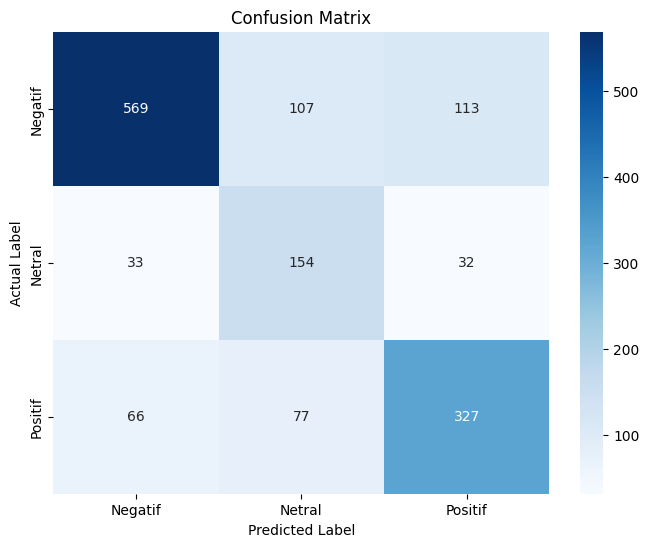

In [65]:
# --------------------------------------------------
# 1. Confussion Matrix & 2. Laporan Klasifikasi
# --------------------------------------------------

print("Evaluating model on the test data...")

# 1. Make predictions on the test set
y_pred = model.predict(X_test)

# 2. Generate and print Classification Report
print("\n--- Classification Report ---")
# 'zero_division=0' prevents errors if a label has no predictions
print(classification_report(y_test, y_pred, zero_division=0))


# 3. Generate and plot Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique()) # Get labels in alphabetical order

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 6. Data Prediksi

In [66]:
# --------------------------------------------------
# Predict on new, unseen data
# --------------------------------------------------

print("Starting prediction on new, unseen posts...")

# 1. Create new sample posts
new_posts = [
    "This is a terrible war. I hope it ends soon.",
    "I just saw a report on UNRWA, it is very good news.",
    "Biden and Netanyahu must push for peace.",
    "This is just a protest, nothing more."
]

print(f"\nPredicting sentiment for {len(new_posts)} new posts...\n")

# 2. Loop and apply the full pipeline
for raw_text in new_posts:
    final_string = preprocess_text(raw_text)
    vector = vectorizer.transform([final_string])
    prediction = model.predict(vector)

    # --- Display Result ---
    print(f"Original Text: {raw_text}")
    print(f"Cleaned Text: {final_string}")
    print(f"Predicted Sentiment: {prediction[0]}")
    print("-" * 30)

Starting prediction on new, unseen posts...

Predicting sentiment for 4 new posts...

Original Text: This is a terrible war. I hope it ends soon.
Cleaned Text: terrible war hope soon
Predicted Sentiment: Negatif
------------------------------
Original Text: I just saw a report on UNRWA, it is very good news.
Cleaned Text: saw UNRWA good
Predicted Sentiment: Positif
------------------------------
Original Text: Biden and Netanyahu must push for peace.
Cleaned Text: Biden Netanyahu push peace
Predicted Sentiment: Positif
------------------------------
Original Text: This is just a protest, nothing more.
Cleaned Text: protest nothing
Predicted Sentiment: Negatif
------------------------------
